# **Desafio - Dev Python**

&nbsp;&nbsp;&nbsp;&nbsp;Com base nas instruções fornecidas para a execução do desafio, foram realizados os seguintes passos:

## **Avaliação dos dados**

&nbsp;&nbsp;&nbsp;&nbsp;Para uma manipulação mais assertiva dos dados, foi feita uma primeira avaliação dos dados contidos dentro dos arquivos disponibilizados, pois dessa forma, foi possível criar um mapemamento de como o pipeline do ETL iria ocorrer.   

&nbsp;&nbsp;&nbsp;&nbsp;Após a abertura de todos os arquivos, chegou-se as seguites conclusões:
- Os arquivos Adult.data e Adult.test não possuem cabeçalho;
- O arquivo Adult.test possui na primeira linha ***1x3 Cross validator*** dando a entender que na verdade esses dois arquivos são o resultado de um ***Data Splitting*** e que os dois arquivos foram utilizados para treinamento de um modelo de Machine Learning. Sendo um arquivo para a validação e o outro para o treinamento do modelo;
- No arquivo Description estão os cabeçalhos da tabela;
- No arquivo Description contém o tipo dos dados: categóricos e numéricos;
- Ainda no arquivo Description, existe uma última coluna com o nome ***class***, termo utilizado em modelos de ML, que fazem referência a uma coluna utilizada para alguma previsão, mais uma pista que os dados foram utilizados na criação de um modelo. 

&nbsp;&nbsp;&nbsp;&nbsp;Antes do início do processo de ETL, foi feita uma varredura nos dados para identificar se existia algum registro nas colunas que não corresponde com a categoria da coluna.

In [20]:
import pandas as pd

adult_data = pd.read_csv('../data/Adult.data', header=None, sep=',')
for c in adult_data.columns:
    print (f"Coluna {c}: {adult_data[c].unique()}")

Coluna 0: ['39' '50' '38' '53' '28' '37' '49' '52' '31' '42' '30' '23' '32' '40'
 '34' '25' '43' '54' '35' '59' '56' '19' '20' '45' '22' '48' '21' '24'
 '57' '44' '41' '29' '18' '47' '46' '36' '79' '27' '67' '33' '76' '17'
 '55' '61' '70' '64' '71' '68' '66' '51' '58' '26' '60' '90' '75' '65'
 '77' '62' '63' '80' '72' '74' '69' '73' '81' '78' '88' '82' '83' '84'
 '85' 'B' '86' '87' 'D']
Coluna 1: [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
Coluna 2: [' 77516' ' 83311' ' 215646' ... ' 34066' ' 84661' ' 257302']
Coluna 3: [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
Coluna 4: [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
Coluna 5: [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
Coluna 6: 

&nbsp;&nbsp;&nbsp;&nbsp;Dessa forma, foi possível identificar ***letras*** em colunas numéricas e ***?*** em colunas categóricas.   
&nbsp;&nbsp;&nbsp;&nbsp;Finalizada essa etapa de avaliação, começou-se o processo de elaboração do script.

## **ETL > Extração**

Para a extração, foi criada uma função que recebe por parâmetro o número de linhas a serem processadas (1630) e as linhas do arquivo que devem ser desconsideradas, para não existir reprocessamento nos ciclos do script. 

In [ ]:
adult_data, adult_test = load_adult_datasets(
        first_n_lines = None if not auto else num_lines_to_process,
        skip_lines = (lines_processed_data, lines_processed_test)
    )

&nbsp;&nbsp;&nbsp;&nbsp;No início da função, é feita a extração do nome das colunas e a categoria de dado de cada uma delas do arquivo Description.   
&nbsp;&nbsp;&nbsp;&nbsp;É lido o arquivo inteiro e a string ajustada de forma que cada nome de coluna fique numa única linha após o ***Attribute type:***. Dessa forma, foi possível extrair o nome de cada uma delas e já substituir o - por _ para uma melhor utilização no banco de dados.   
&nbsp;&nbsp;&nbsp;&nbsp;Além disso, a categoria da coluna também foi extraída com o auxílio do termo ***continuous*** que indicava um valor numérico. 

In [ ]:
def parse_header_info():
    headers = []
    data_type = []
    lines = ""

    with open('data/Description', 'r') as f:
        lines = f.read()

    lines = lines.replace(': \n', ':').split('\n')

    attributes_index_start = 0

    for i in range(len(lines)):
        if "Attribute type" in lines[i]:
            attributes_index_start = i + 1
    
    for i in range(attributes_index_start, len(lines)):
        if lines[i].strip() == '':
            break

        header_metadata = lines[i].split(':')
        headers.append(header_metadata[0].strip().replace('-', '_'))

        is_data_type_numeric = 'continuous' in header_metadata[1]
        data_type.append(is_data_type_numeric)

    return headers, data_type

&nbsp;&nbsp;&nbsp;&nbsp;Com os cabeçalhos e categorias das colunas, então é criado o dataframe do bloco de linhas que está sendo extraído do csv original.

In [ ]:
try:
    adult_data = pd.read_csv('data/Adult.data', header=None, sep=',', skiprows=skip_lines[0], nrows=first_n_lines)
except pd.errors.EmptyDataError:
    adult_data = pd.DataFrame(columns=headers)

try:
    adult_test = pd.read_csv('data/Adult.test', header=None, sep=',', skiprows=1 + skip_lines[1], nrows=first_n_lines)
except pd.errors.EmptyDataError:
    adult_test = pd.DataFrame(columns=headers)

&nbsp;&nbsp;&nbsp;&nbsp;Como os dois arquivos csv contém a mesma estrutura, ambos foram tratados da mesma forma, para evitar duplicação de código.   
&nbsp;&nbsp;&nbsp;&nbsp;Então são adicionada as colunas ao dataframe. Se o dataframe não estiver vazio, ele itera pelas colunas, já fazendo um primeiro tratamento.   
&nbsp;&nbsp;&nbsp;&nbsp;Caso a categoria da coluna for categórica, ele substitui os ***?*** por nulo. 

In [ ]:
for data in [adult_data, adult_test]:
    data.columns = headers

    if len(data) > 0:
        for i in range(len(headers)):
            if data_type[i]:
                data[headers[i]] = data[headers[i]].parallel_apply(lambda x: try_convert_numeric(x))
            else:
                data[headers[i]] = data[headers[i]].astype(str)
                data[headers[i]] = data[headers[i]].parallel_apply(lambda x: None if x.strip() == '?' else x.strip())

&nbsp;&nbsp;&nbsp;&nbsp;
Neste caso, foi utilizado o ***parallel_apply()*** no lugar do ***apply()*** do Pandas, por ser multithread, otimizando a execução do script. 
&nbsp;&nbsp;&nbsp;&nbsp;Se a categoria da coluna for numérica, ele valida se é um número válido, se não for, ele retorna nulo, com o auxílio de uma função.

In [ ]:
def try_convert_numeric(value):
    try:
        return float(value)
    except Exception:
        return None

## **ETL > Transformação**

&nbsp;&nbsp;&nbsp;&nbsp;Dando continuidade a etapa anterior, nessa etapa, é feita a normalização dos dados e também o tratamento aos dados nulos. 

In [ ]:
for data in [(adult_data, "AdultData"), (adult_test, "AdultTest")]:
    dataset, name = data

    dataset = handle_missing_data(dataset)

&nbsp;&nbsp;&nbsp;&nbsp;É criado um dicionário com a quantidade de registros nulos para cada coluna. Caso existam valores nulos na coluna, então é feito o tratamento:
- Se a coluna for numerica, é feita uma média com todos os valores da coluna e esse valor é inserido no lugar do valor nulo;
- Se for categórica, então é pego o valor com mais ocorrências na coluna e este adicionado no lugar do valor nulo;

In [ ]:
def handle_missing_data(data):
    missing_data = dict(data.isnull().sum())

    for column, missing_count in missing_data.items():
        if missing_count > 0:
            print(f"{column} has {missing_count} missing values.")

            if data[column].dtype == 'int64' or data[column].dtype == 'float64':
                print(f"{column} has missing values. Replacing with mean.\n")
                data[column].fillna(data[column].mean(), inplace=True)
            else:
                print(f"{column} has missing values. Replacing with mode.\n")
                data[column].fillna(data[column].mode()[0], inplace=True)

    return data

## **ETL > Carga**

&nbsp;&nbsp;&nbsp;&nbsp;Por fim, os dados são inseridos no banco de dados SQLite. Primeiro é feita uma validação se a tabela já existe no banco. 

In [ ]:
def insert_data(table_name, dataset):

    check_sqlite_table(table_name, dataset)

    dataset.to_sql(
        name=table_name,
        if_exists='append',
        index=False,
        method='multi', 
        chunksize=200,
        con=load_sqlite_database()
    )

&nbsp;&nbsp;&nbsp;&nbsp;Caso não exista, é criada respeitando a categoria de dados que cada coluna contém. Também foi adicionada uma coluna **id** para ser a ***PK*** da tabela. 

In [ ]:
def check_sqlite_table(table_name, base_dataset):
    if not sqlalchemy.inspect(load_sqlite_database()).has_table(table_name):
        field_and_types = ""

        for column_name, dtype in zip(base_dataset.columns, base_dataset.dtypes):

            if dtype == 'float64' or dtype == 'int64':
                field_and_types += f"{column_name} REAL,"
            else: 
                field_and_types += f"{column_name} TEXT,"

        conn = load_sqlite_database().connect()
        trans = conn.begin()

        conn.execute(f"""
            CREATE TABLE {table_name}
                (id INTEGER PRIMARY KEY AUTOINCREMENT,
                {field_and_types[:-1]}); 
        """)

        trans.commit()

## **Agendamento**

&nbsp;&nbsp;&nbsp;&nbsp;Foi utilizado o  ***Crontab*** para realizar o agendamento do script. Como essa ferramenta não permite agendamentos em segundos, então foi feita uma lógica para que o script rode internamente a cada 10 segundos, porém sendo agendado a cada ***um minuto*** pelo ***Crontab***.

In [ ]:
start_time = time.time()
pipeline_main(periodic) 

for i in range(5):
    while (time.time() - start_time) <= 10:                
        time.sleep(0.02)

    pipeline_main(periodic)

    start_time = time.time()

&nbsp;&nbsp;&nbsp;&nbsp;O tempo no início da primeira execução do pipeline é gravado numa variável, e após finalizar esta execução, o script faz uma série de iterações, onde o script aguarda ***10 segundos*** para rodar novamente um pipeline.   
&nbsp;&nbsp;&nbsp;&nbsp;Antes de finalizar cada iteração, a variável com o tempo é resetada, para garantir que ele sempre consiga esperar os 10 segundos em todas as iterações subsequentes.   
&nbsp;&nbsp;&nbsp;&nbsp;Dessa forma, o pipeline é acionado 6 vezes (a cada 10 segundos) a cada minuto, e o agendador é acionado a cada 1 minuto.

## **Processamento em blocos**

&nbsp;&nbsp;&nbsp;&nbsp;Para que o pipeline processasse apenas 1630 registros por vez, foi utilizado o ***pickle***, pois com ele, é possível gravar na pasta raiz do script, quantos os registros já foram processados a cada pipeline.   
&nbsp;&nbsp;&nbsp;&nbsp;Para esse desafio em especial, assumiu-se que os dados da tabela não são alterados depois que eles vão para o banco de dados.   
&nbsp;&nbsp;&nbsp;&nbsp;Duas funções foram elaboradas:
- ***get_processed_lines_read()***: Que retorna as últimas linhas processadas no arquivo csv original;
- ***set_processed_lines_read()***: Que adiciona as últimas linhas processadas em variáveis globais. 

In [ ]:
if os.path.exists('processed_lines.pkl'):
    processed_lines = pickle.load(open('processed_lines.pkl', 'rb'))
   
    set_processed_lines_read(processed_lines['data'], processed_lines['test'])

lines_processed_data, lines_processed_test = get_processed_lines_read()

&nbsp;&nbsp;&nbsp;&nbsp;No inicio do pipeline, é feita a validação se já existe um arquivo ***pickle***, se sim, ele é lido e os valores inseridos nele são inseridos nas variáveis globais do script.   
&nbsp;&nbsp;&nbsp;&nbsp;Caso ele não exista, então é utilizado o valor padrão dessas variáveis. 

In [ ]:
lines_processed_data = 0
lines_processed_test = 0

def get_processed_lines_read():
    return lines_processed_data, lines_processed_test

def set_processed_lines_read(crd, crt):
    global lines_processed_data
    global lines_processed_test

    lines_processed_data, lines_processed_test = crd, crt

&nbsp;&nbsp;&nbsp;&nbsp;Somente depois de pegar esses valores das variáveis, que começa a fase de ***extração*** do ETL. 

In [ ]:
lines_processed_data, lines_processed_test = get_processed_lines_read()

    # ETL Phase 1 - Extract >> Get datasets 
    adult_data, adult_test = load_adult_datasets(
        first_n_lines = None if not auto else num_lines_to_process,
        skip_lines = (lines_processed_data, lines_processed_test)
    )

&nbsp;&nbsp;&nbsp;&nbsp;Quando o ETL é concluído, ou seja, após a fase de ***carga***, os valores contidos nas variáveis globais são inseridos novamente no arquivo ***pickle***, mantendo assim o registro de quais foram as últimas linhas processadas do arquivo csv original. 

In [ ]:
lines_processed_data, lines_processed_test = get_processed_lines_read()
pickle.dump({ 'data': lines_processed_data, 'test': lines_processed_test }, open('processed_lines.pkl', 'wb'))

&nbsp;&nbsp;&nbsp;&nbsp;
Dessa forma, existe um controle de quais registros foram processados, fazendo com que a mesma linha do csv não seja processada mais de uma vez.

## **EXTRA I - Análise Exploratória de Dados**

&nbsp;&nbsp;&nbsp;&nbsp;Foi inserido no script, uma opção para rodar uma análise exploratória dos dados. Ela vem logo após a fase ***transformação*** do ETL, pois para ela funcionar corretamente, todos o dataframe não pode conter registros que não condizem com a categoria das colunas.

In [1]:
run_eda = True

if run_eda and not auto:
    run_exploratory_data_analysis(dataset, name)

&nbsp;&nbsp;&nbsp;&nbsp;A biblioteca utilizada para essa análise foi a ***sweetviz***.   
&nbsp;&nbsp;&nbsp;&nbsp;Após a conclusão da análise, um arquivo ***.html *** é criado e salvo para auxiliar na extração de insights.

In [15]:
import sweetviz as sv
import os

def run_exploratory_data_analysis(data, name):

    if not os.path.exists('EDA'):
        os.makedirs('EDA')

    data_report = sv.analyze(data, pairwise_analysis="on")
    data_report.show_notebook()

                                             |                            | [  0%]   00:00 -> (? left)


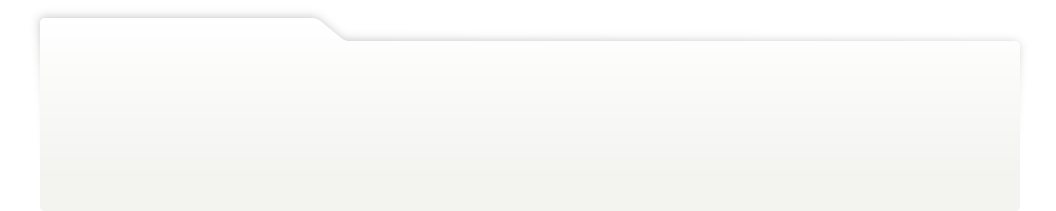
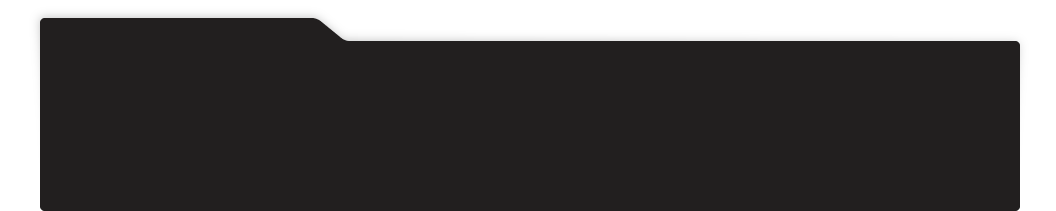
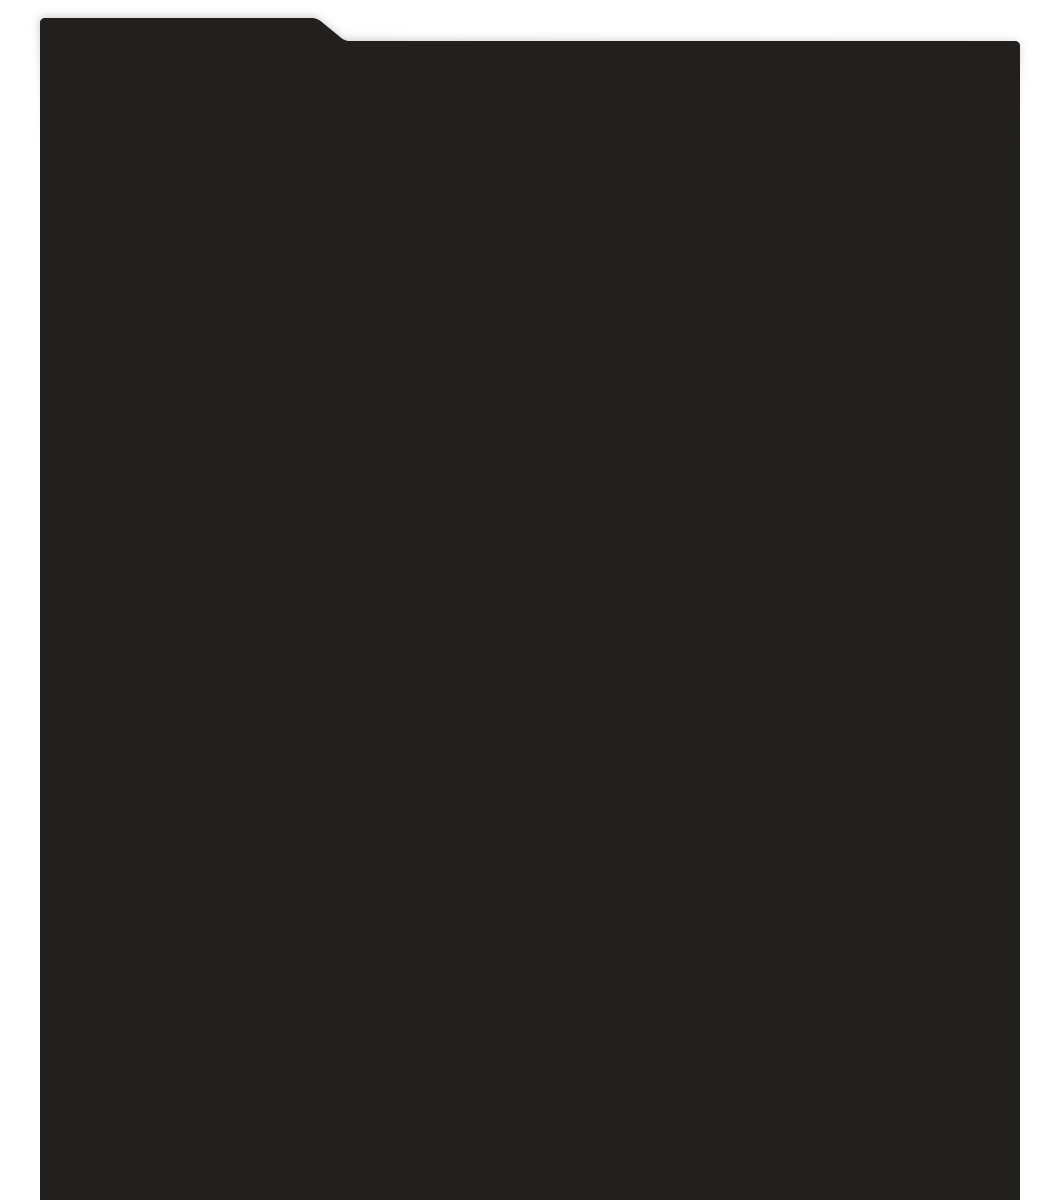
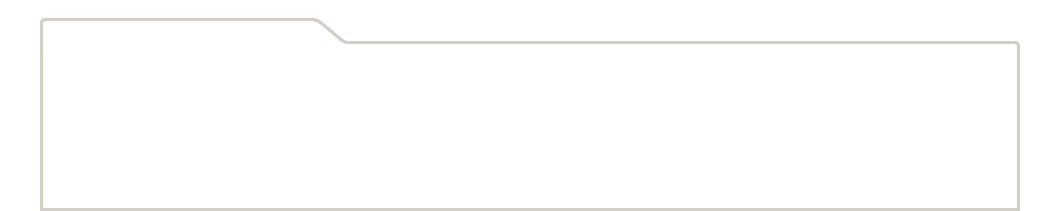
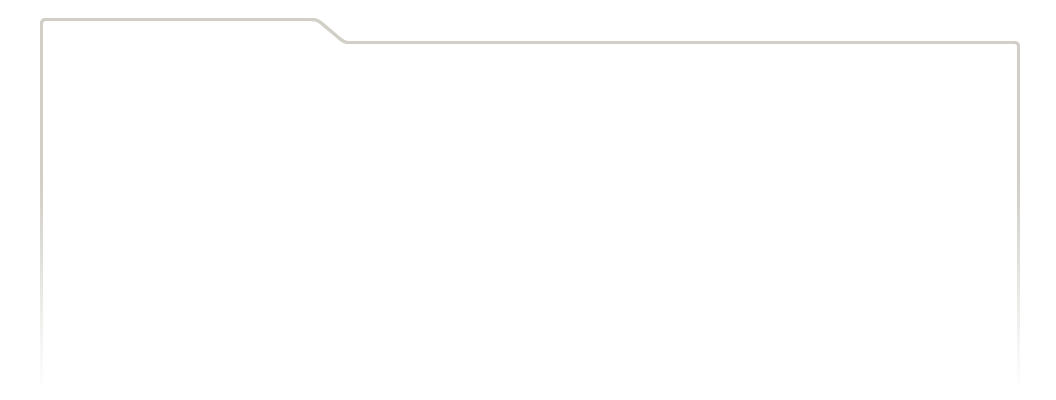
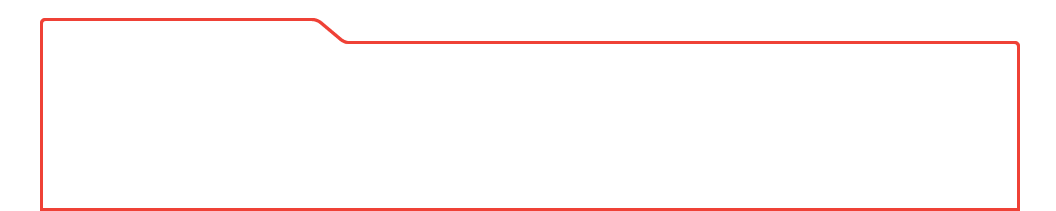
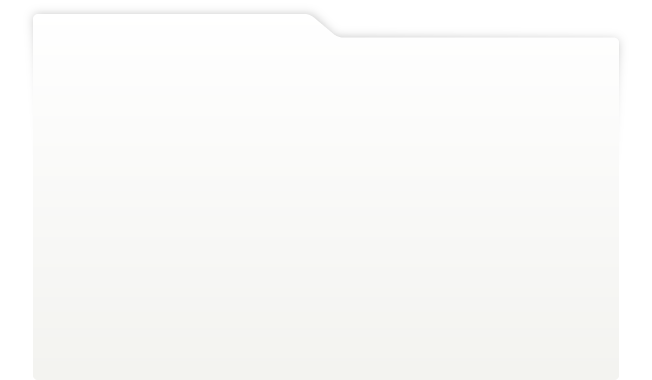
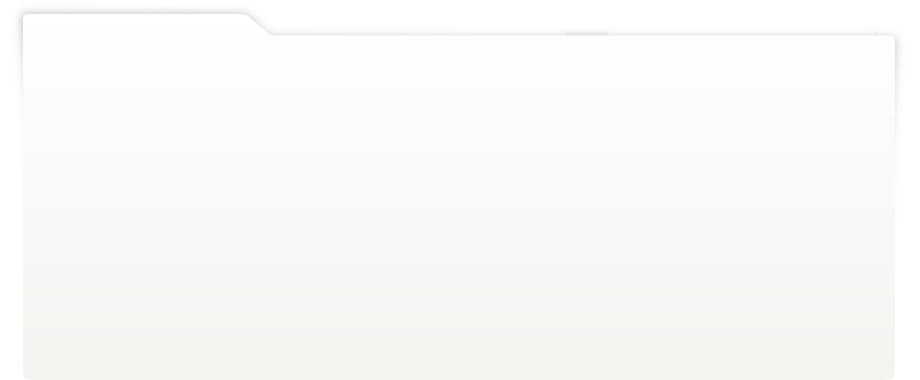
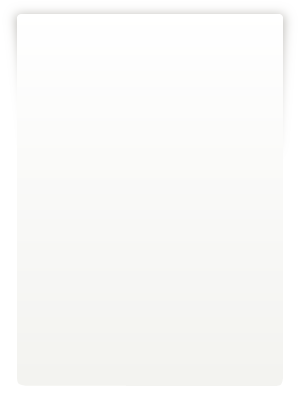
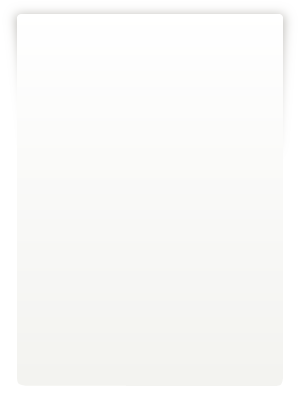
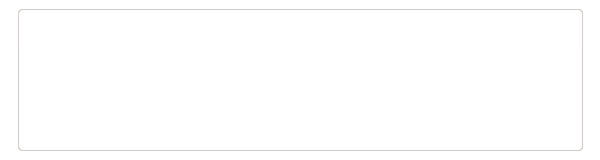
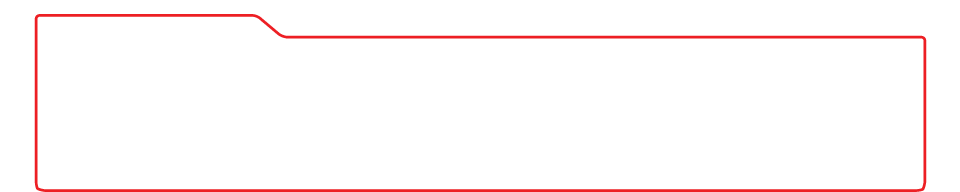
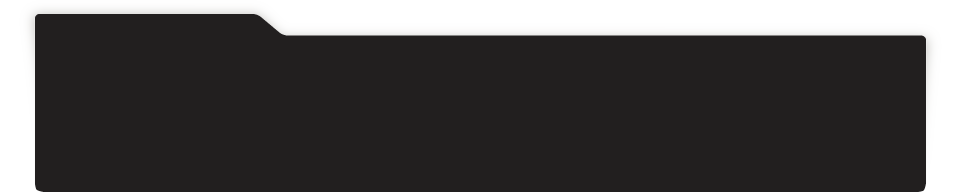
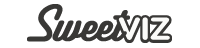
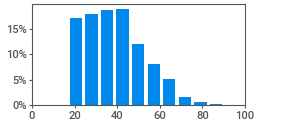
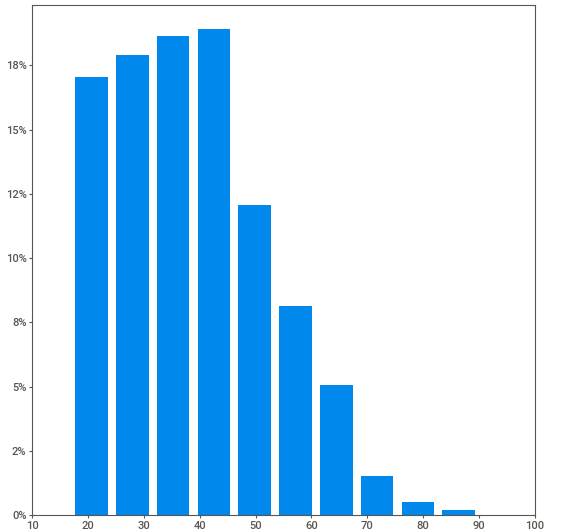
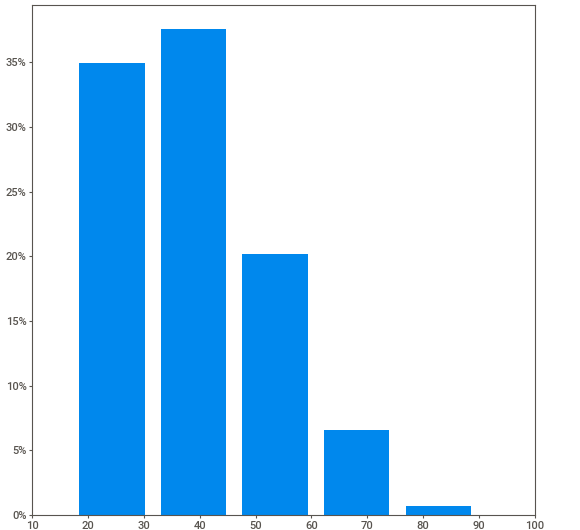
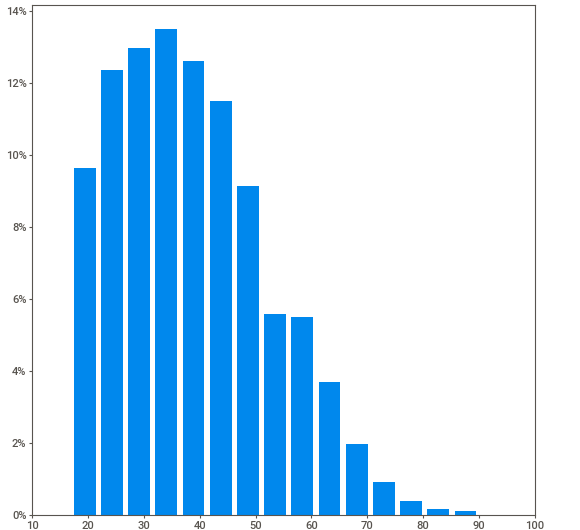
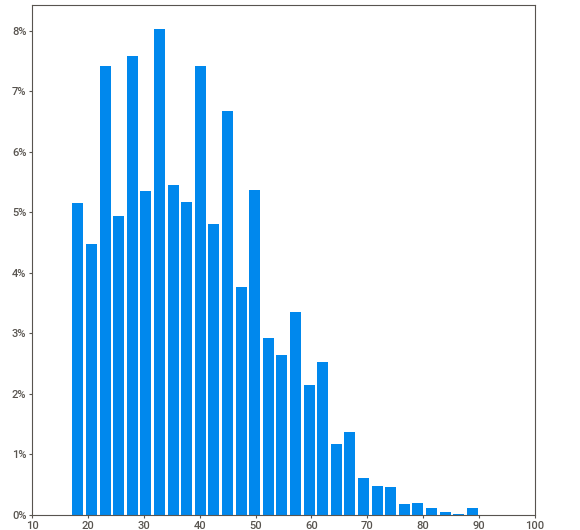
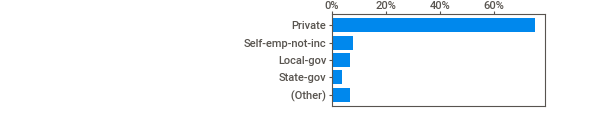
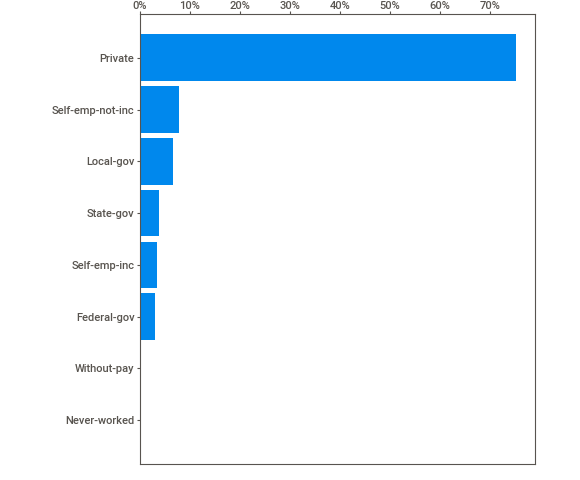
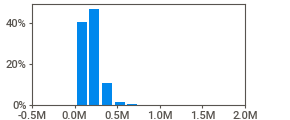
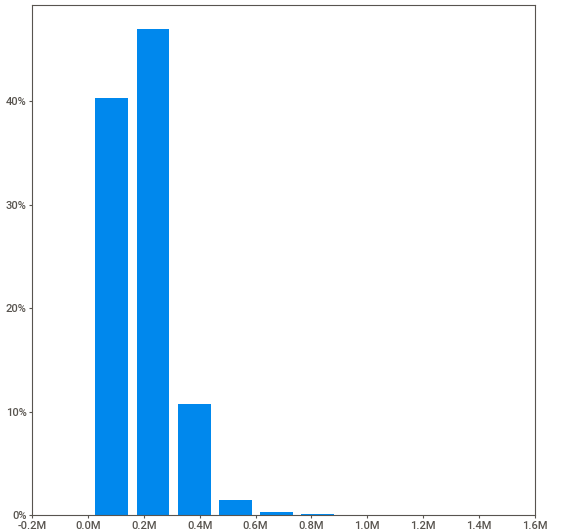
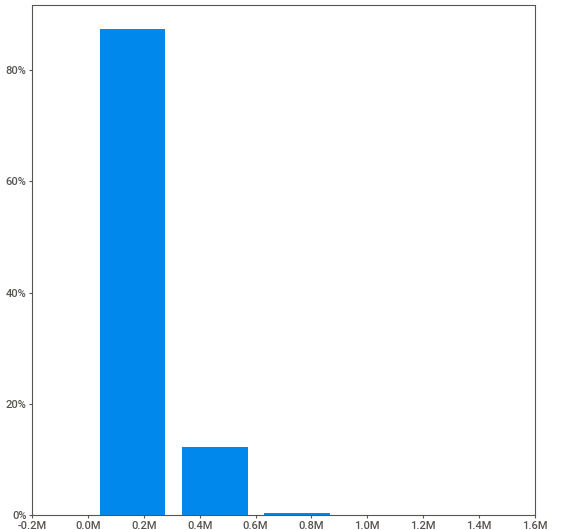
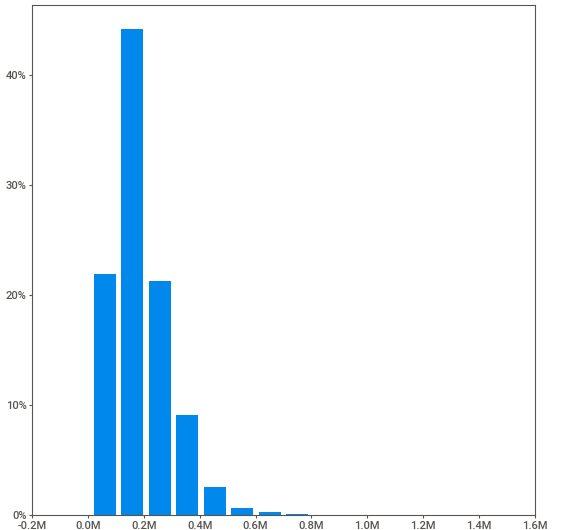
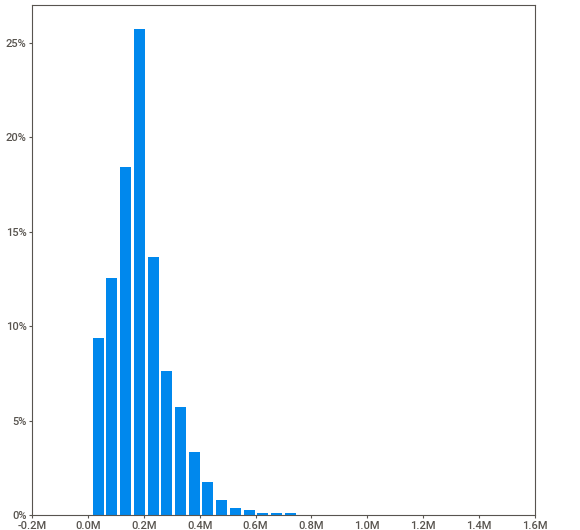
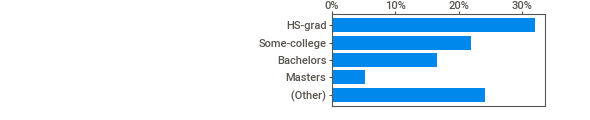
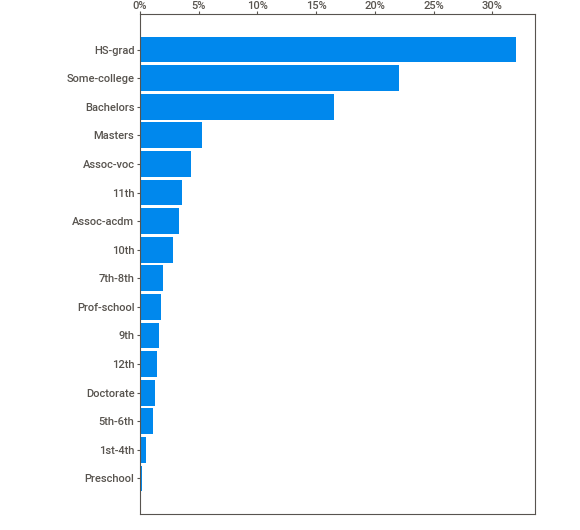
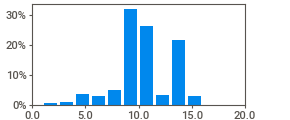
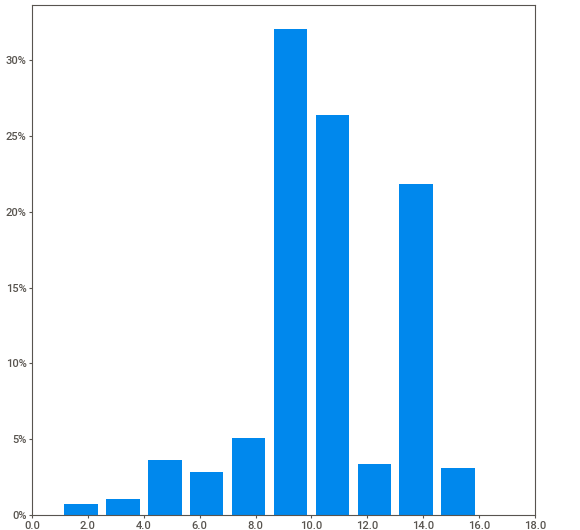
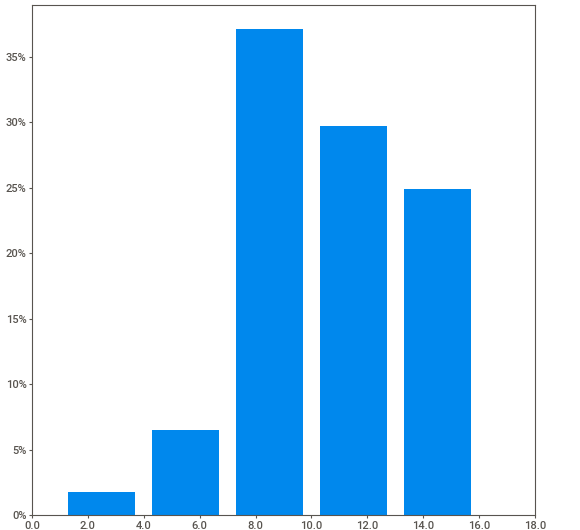
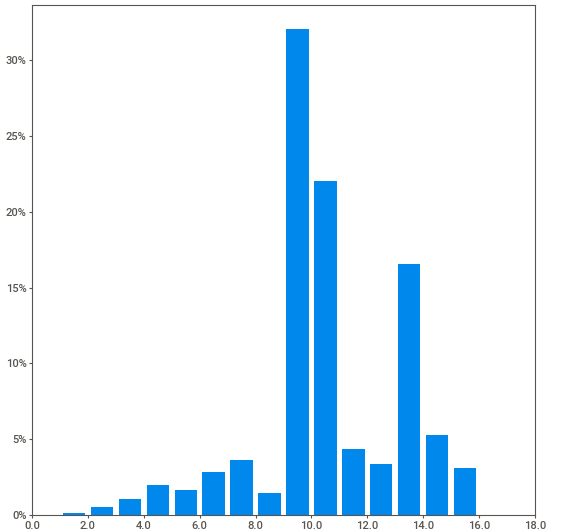
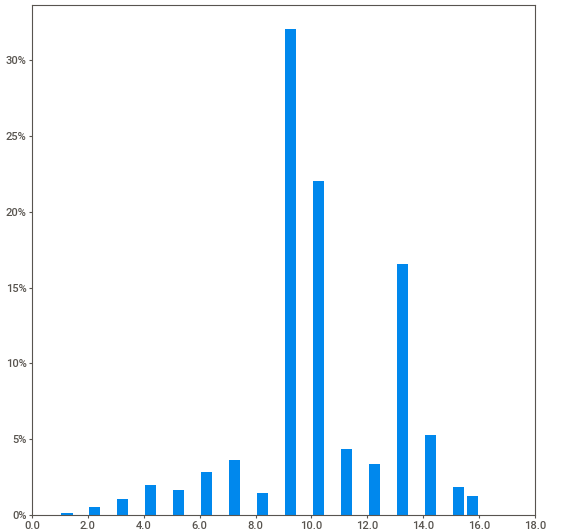
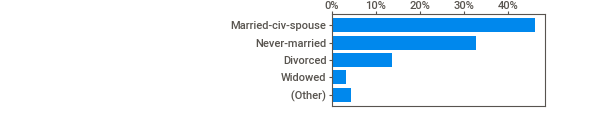
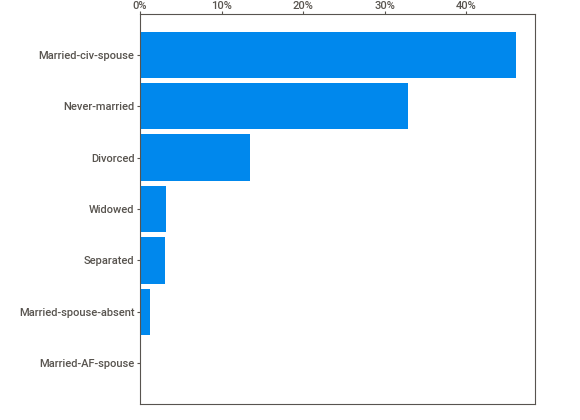
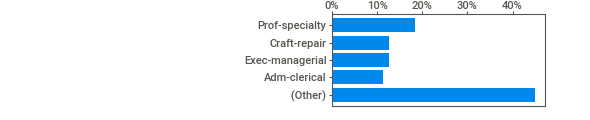
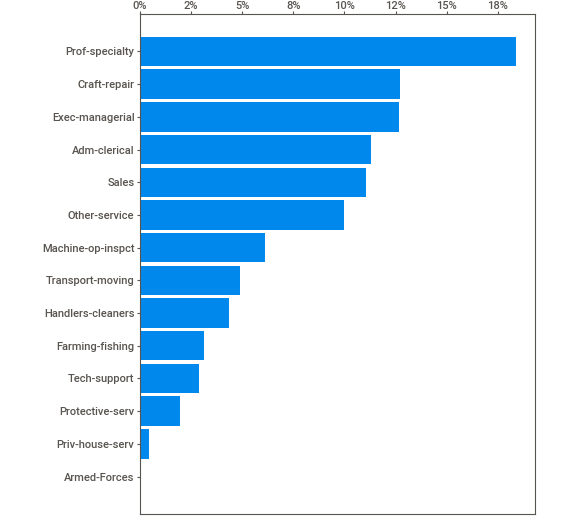
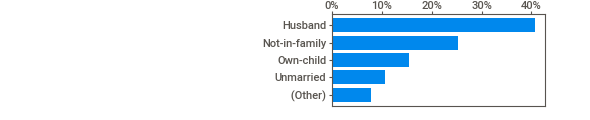
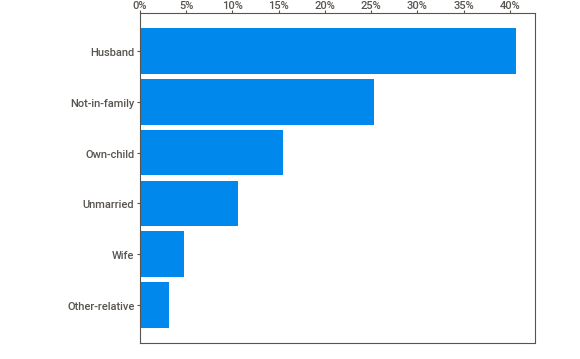
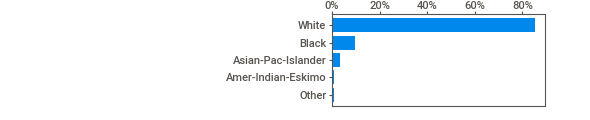
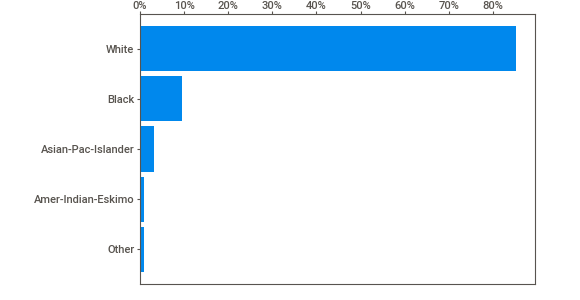
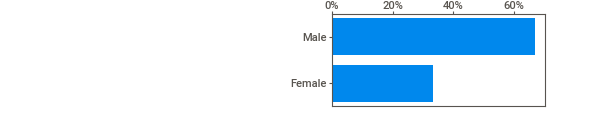
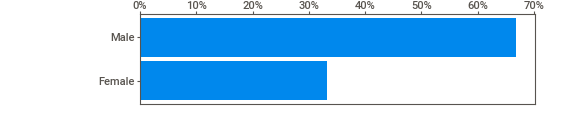
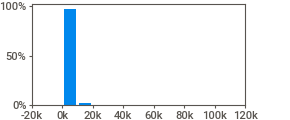
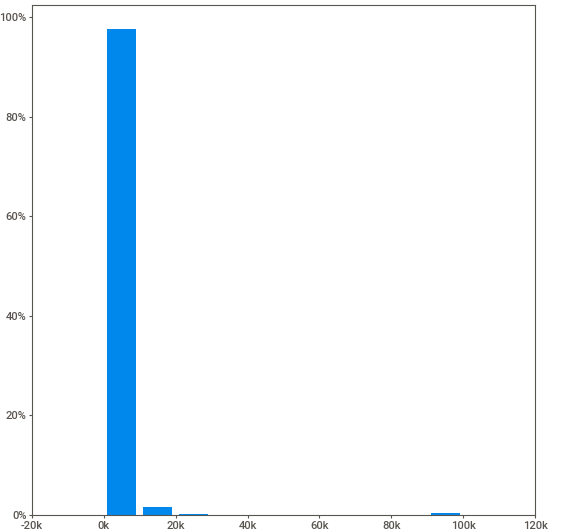
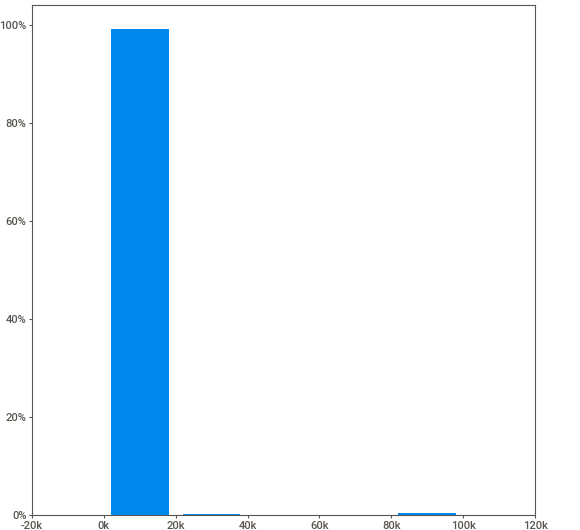
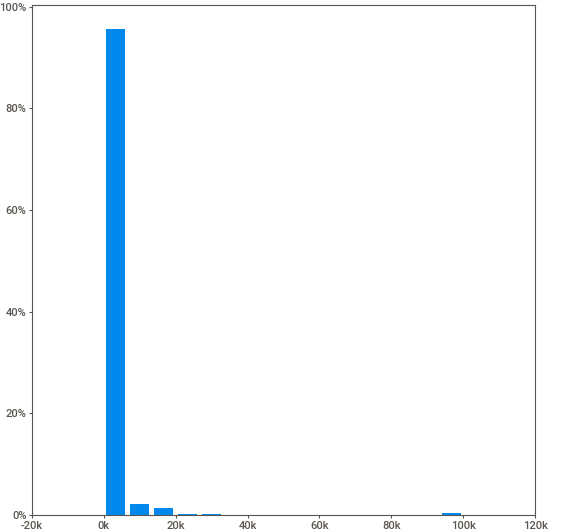
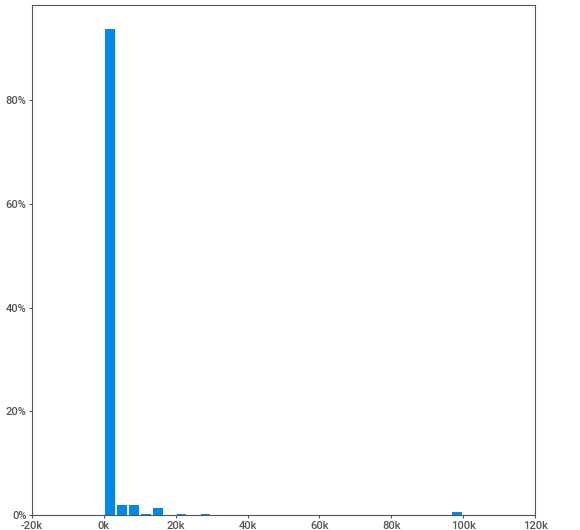
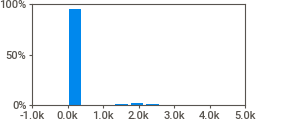
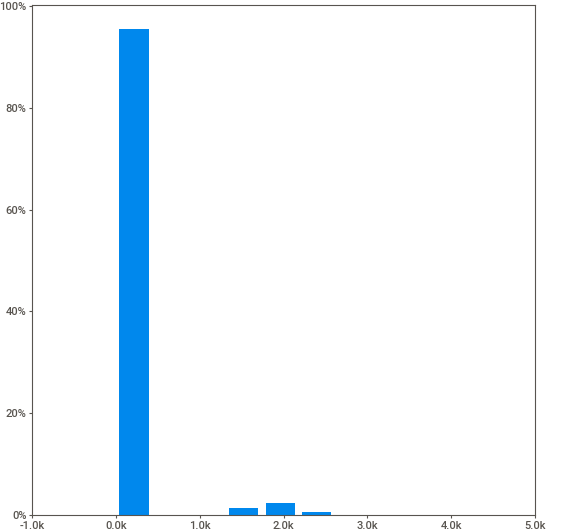
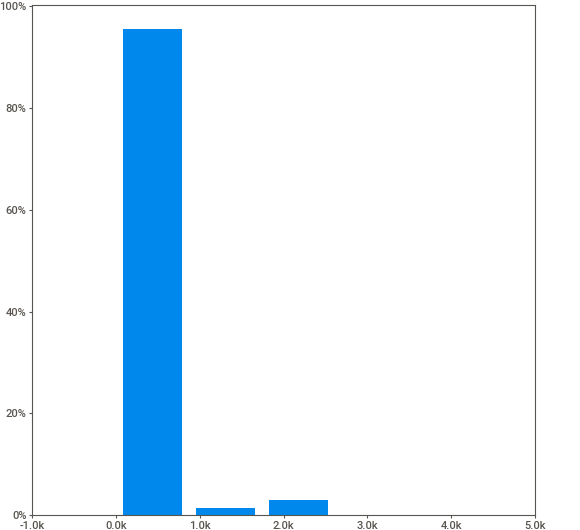
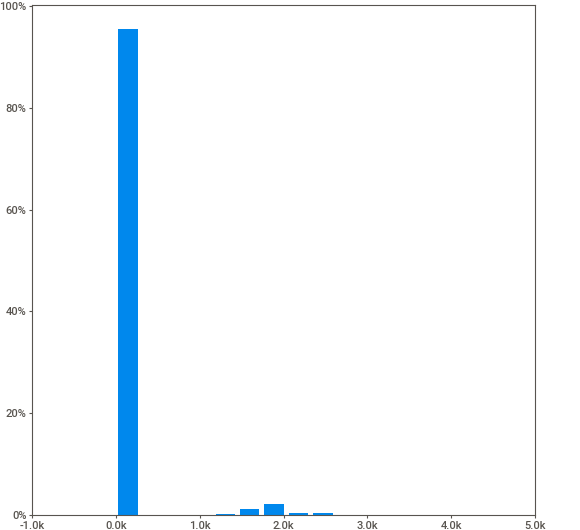
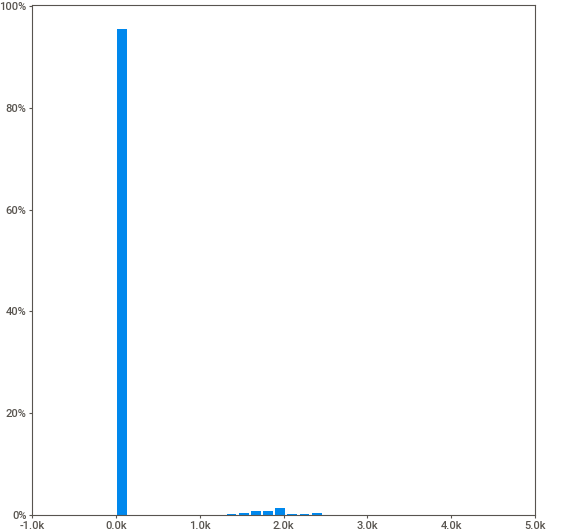
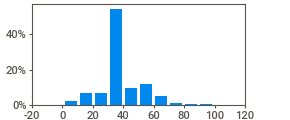
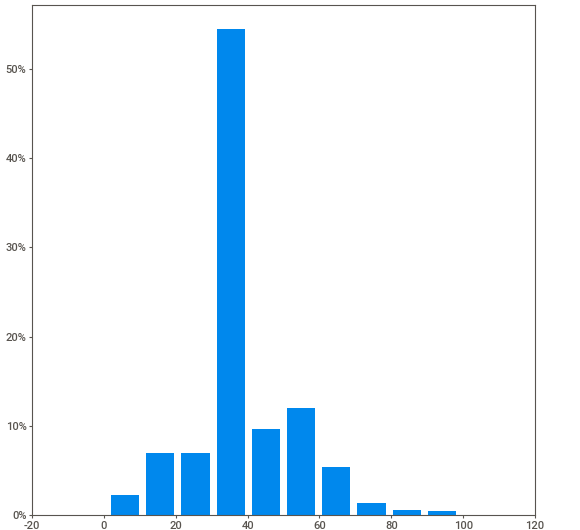
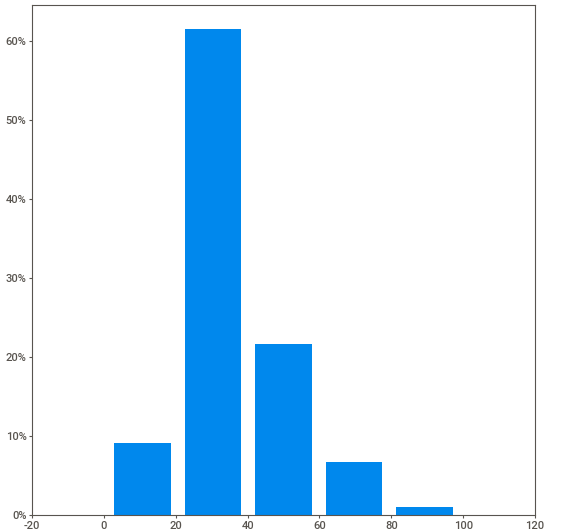
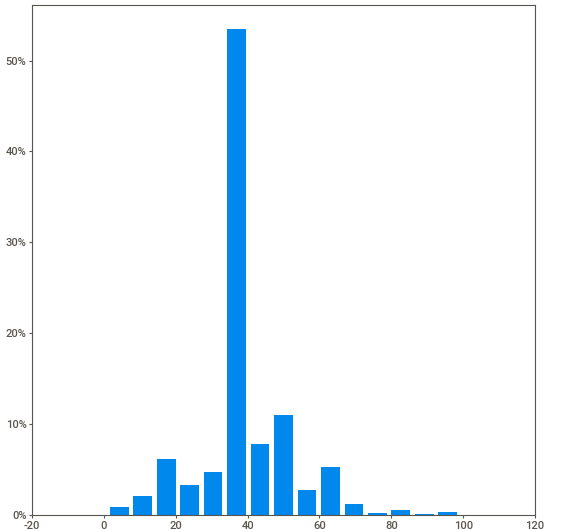
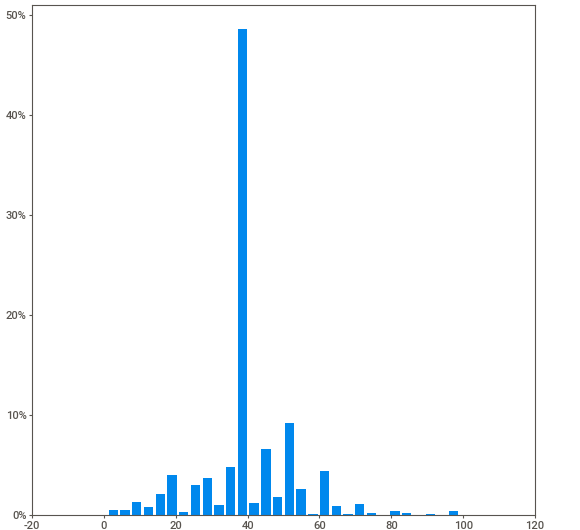
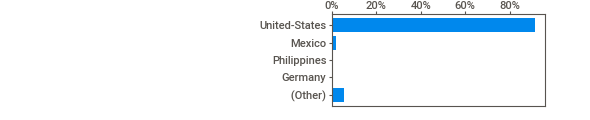
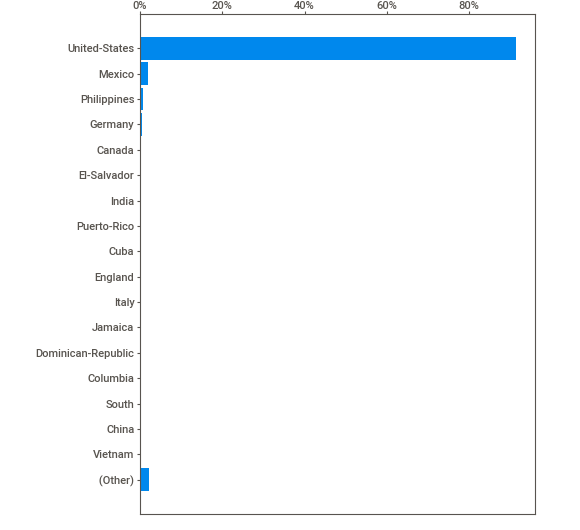
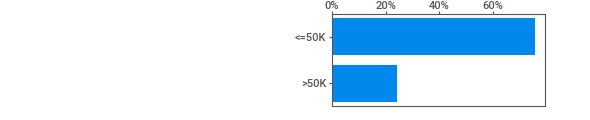
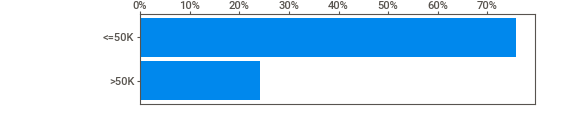
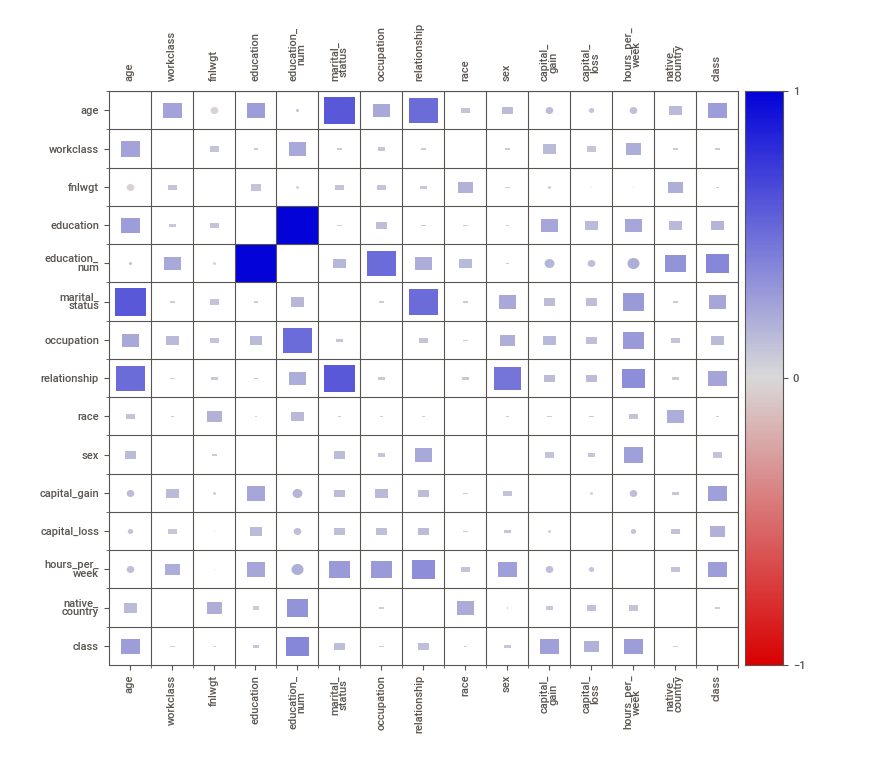
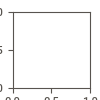

In [16]:
run_exploratory_data_analysis(data, name)

## **EXTRA II - Modelo de Machine Learning**

&nbsp;&nbsp;&nbsp;&nbsp;Assim como o EDA, também foi elaborado um modelo de Machine Learning para criar previsão de uma determinada coluna com base nos dados fornecidos.   
&nbsp;&nbsp;&nbsp;&nbsp;Além da previsão, ainda são extraídos o grau de importância de cada coluna para aquela tomada de decisão. Mais uma ferramenta para auxiliar na extração de insights.

In [ ]:
get_insights = True
if get_insights and not auto:
    get_importance_of_attributes_to_class(adult_data, 'class')

&nbsp;&nbsp;&nbsp;&nbsp;Para esse modelo, foi utilizada a coluna class, e a previsão a ser feita é:   
***Quanto um indivíduo faria no ano com base em seus dados estatísticos: Mais ou menos de $50.000,00?***

In [ ]:
def get_importance_of_attributes_to_class(dataset, _class):
    x, y = dataset.drop(_class, axis=1), dataset[_class]
    clf = RandomForestClassifier()
    enc = OrdinalEncoder()
    y = enc.fit_transform(y.values.reshape(-1, 1)).ravel()

    original_column_names = list(x.columns)
    original_column_names = sorted(original_column_names, reverse=True)

    x = pd.get_dummies(x)

    clf.fit(x,y)
    feat_importances = get_feature_importance(clf, original_column_names)

    print('Importances of attributes to how much money an adult would make:')
    for f, i in feat_importances.items():
        print(f'{f} : {round(i*100, 2)}%')

    feat_importances[_class] = 'Prediction Label'
    importance = pd.DataFrame([feat_importances])
    insert_data("feature_importance", importance)

&nbsp;&nbsp;&nbsp;&nbsp;Foi utilizado um ***OrdinalEncoder*** para converter a coluna categórica de previsão para números inteiros, além de utilizar o ***OneHotEncoder*** (através do pd.get_dummies) para converter as colunas categórias para valores binários, que indicam a categoria de cada linha.
&nbsp;&nbsp;&nbsp;&nbsp;Também foi extraído o nome original do dataframe, pois quando as colunas são divididas, essas novas colunas contêm o nome original da coluna como prefixo do seu nome.   
&nbsp;&nbsp;&nbsp;&nbsp;Após o treinamento do modelo, é chamada a função que pega o grau de importância de cada coluna para aquela tomada de decisão. 

In [ ]:
def get_feature_importance(model, original_column_name):
    feature_importances = pd.DataFrame(model.feature_importances_,
                                        index=model.feature_names_in_,
                                        columns=['importance']).sort_values('importance', ascending=False)

    importances = { feature : 0 for feature in original_column_name }

    for index, row in feature_importances.iterrows():
        feature_name = index.strip()
        curr_importance = row[0]
        
        for feature in original_column_name:
            if feature.startswith(feature_name):
                importances[feature] += curr_importance
                break
    
    return importances

&nbsp;&nbsp;&nbsp;&nbsp;Como as colunas foram divididas, então existe a necessidade de se somar o grau de importância de todas as colunas que têm a mesma origem. Por esse motivo foi salvo o nome original de todas as colunas.   
&nbsp;&nbsp;&nbsp;&nbsp;A função faz a soma dessas colunas com o mesmo prefixo e retorna o valor final de importância para cada coluna original do dataframe.   
&nbsp;&nbsp;&nbsp;&nbsp;Uma nova tabela é criada no banco, guardando as informações referentes ao grau de importância para cada coluna prevista no modelo.

## **>>> IMPORTANTE - Informações adicionais**

### **Observação 1 - Arquivos Crontab** ###

Foram inseridos na pasta ***scheduler*** dois arquivos:
- ***census_bureau_pipeline.sh:*** Arquivo a ser lido pelo ***Crontab*** do Linux;
- ***crontab:*** Script usado no linux para iniciar o Pipeline;

### **Observação 2 - Rodando Pipeline** ###

&nbsp;&nbsp;&nbsp;&nbsp;Existem duas formas de se rodar o pipeline:
- De forma automática pelo ***Crontab***;
- De forma manual pelo terminal;   
&nbsp;&nbsp;&nbsp;&nbsp;Como o pipeline do ETL não necessita do EDA, nem do modelo de ML para funcionar, a ativação dessas duas opções são customizáveis no próprio script.   
&nbsp;&nbsp;&nbsp;&nbsp;Basta que as variáveis (**run_eda** e **get_insights**) estejam como **True** e a variável **auto** como **False**.
O script reconhece de forma automática quando o script é acionado de forma automática pelo ***Crontab*** porque ele inicia o script com o argumento *periodic*.

### **Observação 3 - Requirements** ###

&nbsp;&nbsp;&nbsp;&nbsp;
Todas as bibliotecas utilizadas na elaboração do script se encontram no arquivo de texto ***requirements.txt***